In [1]:
import itertools
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as data
from torchvision.utils import make_grid

from made import MADE
from train import train
from util_funcs import fix_random_seeds, set_printoptions

/home/cinemo-de.internal/ptashev/personal/projects/towards-singularity/made/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 0
fix_random_seeds(seed=seed)
set_printoptions(precision=5, sci_mode=False)

### Learn a **discrete** 2D distribution
We will use *MADE* to model a simple discrete 2D distribution.
Assuming we have some data of the form $x = (x_0, x_1)$, where $x_0, x_1 \in \{0, 1, ..., d-1\}$. The data is drawn from an unknown distribution, the *true distribution*, and we will try to model that distribution using *MADE*.

We will create a dataset of samples from the true distribution and we will train the model on it. Then we will compare the distribution that the model learns from the data to the true distribution.

The 2D distribution for the running example will be created from image pixels.

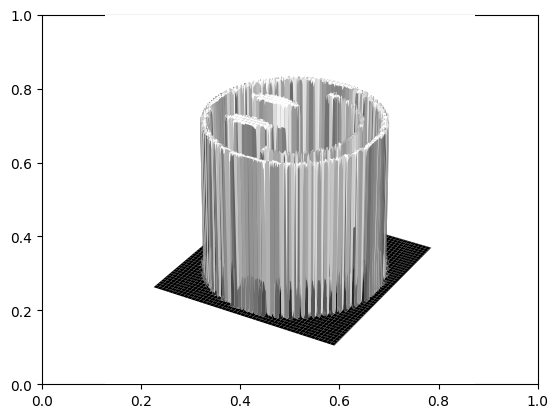

In [4]:
# Load the 2D distribution and plot it in 3D.
with open("data/smiley.pkl", "rb") as f:
    distr = pickle.load(f)

d = len(distr)
xs = np.outer(np.arange(d), np.ones(d))
ys = xs.copy().T

fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax = plt.axes(projection ='3d')
ax.plot_surface(xs, ys, distr, cmap ='gray')#, edgecolor ='gray')
_ = ax.axis("off")

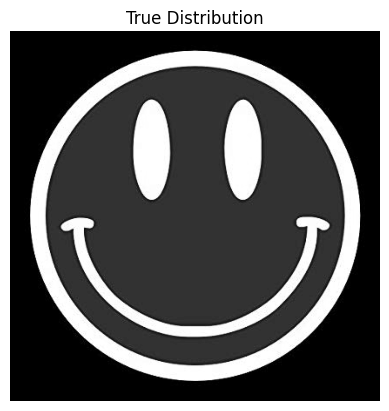

In [5]:
# Plot the distribution as a colormap image.
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.imshow(distr, cmap="gray")
ax.set_title("True Distribution")
_ = ax.axis("off")

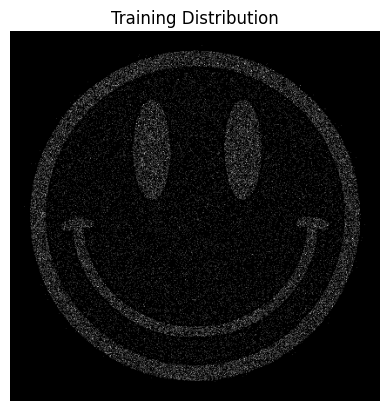

In [15]:
# Generate samples from the distribution.
n = 50_000
pairs = list(itertools.product(range(d), range(d))) # all positions on the image
idxs = np.random.choice(len(pairs), size=n, replace=True, p=distr.reshape(-1))
samples = [pairs[i] for i in idxs]
samples = np.array(samples)

# Plot the distribution resulting from the training data.
train_dist = np.zeros((d, d))
for i in range(len(samples)):
    train_dist[samples[i][0], samples[i][1]] += 1
train_dist /= train_dist.sum()
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.imshow(train_dist, cmap="gray")
ax.set_title("Training Distribution")
_ = ax.axis("off")

In [16]:
# Train the model.
split = int(0.8 * len(samples))
train_data, test_data = samples[:split], samples[split:]

model = MADE(input_shape=(2,), d=d, hidden_sizes=[64, 64], one_hot=True)
train_loss, test_loss = train(
    model, train_data, test_data, train_args={
        "epochs": 100,
        "lr": 1e-4,
        "batch_size": 256,
        "grad_clip": 10,
})

100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


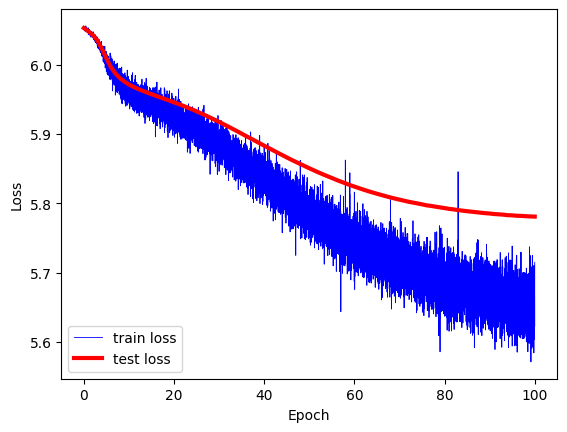

In [17]:
# Plot the loss during training.
n_epochs = len(test_loss) - 1
xs_train = np.linspace(0, n_epochs, len(train_loss))
xs_test = np.arange(n_epochs+1)

fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(xs_train, train_loss, "-b", lw=0.6, label="train loss")
ax.plot(xs_test, test_loss, "-r", lw=3., label="test loss")
_ = ax.legend(loc="lower left")

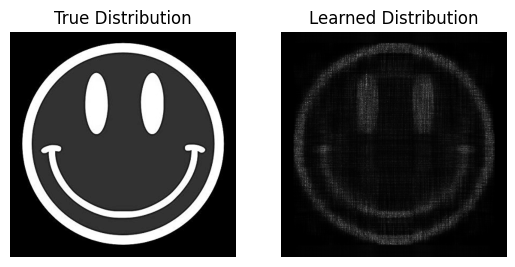

In [18]:
# Plot the learned distribution.
x = np.mgrid[0:d, 0:d].reshape(2, d ** 2).T
x = torch.LongTensor(x)
log_probs = F.log_softmax(model(x), dim=1)
distribution = torch.gather(log_probs, 1, x.unsqueeze(1)).squeeze(1)
distribution = distribution.sum(dim=1).exp().view(d, d).detach().cpu().numpy()
assert np.allclose(np.sum(distribution), 1.), f"Distribution sums to {np.sum(distribution)} != 1"

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6.4, 4.8))
ax1.imshow(distr, cmap="gray")
ax1.set_title("True Distribution")
ax1.axis("off")
ax2.imshow(distribution, cmap="gray")
ax2.set_title("Learned Distribution")
_ = ax2.axis("off")

### Learn to generate binary images from MNIST

Train *MADE* to model the probability distribution of the binarized MNIST dataset. Given a binary image of height $H$ and width $W$, $x \in \{0, 1\}^{H \times W}$, we can represent that image as a flattened binary vector $x \in \{0, 1\}^{HW}$.


In [9]:
# Load the MNIST dataset and convert the pixel values to binary values `{0, 1}`.
with open("data/mnist.pkl", "rb") as f:
    dataset = pickle.load(f)

train_data, test_data = dataset["train"], dataset["test"]
train_data = (train_data > 127.5).astype('uint8')
test_data = (test_data > 127.5).astype('uint8')

image_shape = train_data[0].shape[:2]
H, W = image_shape
print(f"image shape: {H}x{W}")

image shape: 28x28


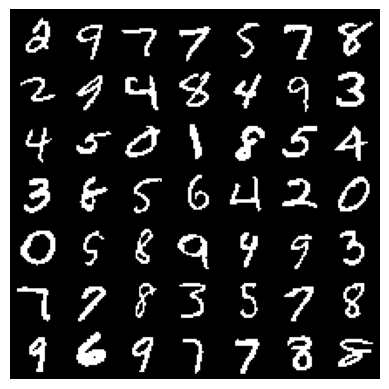

In [10]:
# Plot some images from the dataset.
idxs = np.random.choice(len(train_data), replace=False, size=(49,))
samples = train_data[idxs]
samples = torch.FloatTensor(samples).permute(0, 3, 1, 2)
grid_img = make_grid(samples, nrow=7)
plt.figure()
plt.imshow(grid_img.permute(1, 2, 0))
_ = plt.axis('off')

In [14]:
# Train the model.
model = MADE(input_shape=(H, W, 1), d=2, hidden_sizes=[512, 512], one_hot=False)
train_loss, test_loss = train(
    model, train_data, test_data, train_args={
        "epochs": 250,
        "lr": 1e-4,
        "batch_size": 128,
        "grad_clip": 10,
})

100%|██████████| 250/250 [29:24<00:00,  7.06s/it]


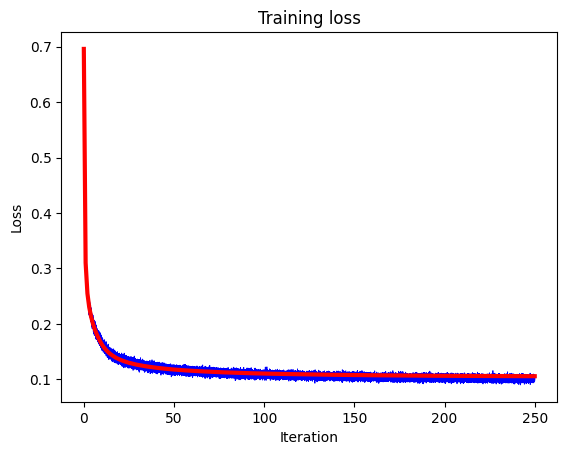

In [15]:
# Plot the loss during training.
n_epochs = len(test_loss) - 1
xs_train = np.linspace(0, n_epochs, len(train_loss))
xs_test = np.arange(n_epochs+1)

fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.set_title("Training loss")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.plot(xs_train, train_loss, "-b", lw=0.6)
_ = ax.plot(xs_test, test_loss, "-r", lw=3.)

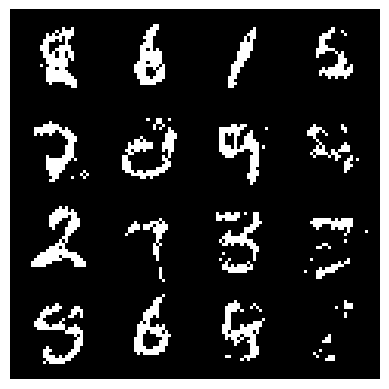

In [16]:
# Plot some images generated by the model.
samples = model.sample(16).permute(0, 3, 1, 2)
grid_img = make_grid(samples, nrow=4)
plt.figure()
plt.imshow(grid_img.permute(1, 2, 0))
_ = plt.axis('off')